# Deep Sets vs RNN

I'm kind of just redoing some of my studies from January to understand where any changes that might have incurred with switching to a new framework, and other changes that I thought were minor in the last few months.

May 2019

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Step 1: Load in the data

In [2]:
subDir = 'mc16d_PFlow_ttbar_ip3d'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
# The pfn model 
dataTagTrain = "3mtrain_15trks_{}".format(vStr)
dataTagTest  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

### Step 2: Load in the models

According to my `Hyperparameter-Scan` notebook, it looks as long as my model had sufficient complexity, they all seemed to be performing about the same, so I'm going to go ahead and use the same one as the default architecture for the quark vs gluon task from the pub note, since I believe this architecture has sufficient flexibility that I can expand the # of track features and still expect that the model is complex enough to learn the higher level features.

Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
acc
loss
val_acc
val_loss


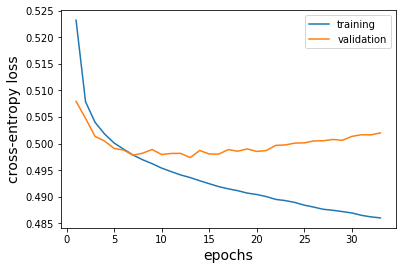

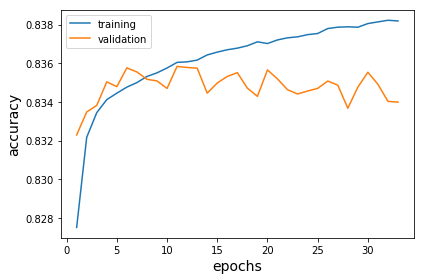

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained PFN
acc
loss
val_acc
val_loss


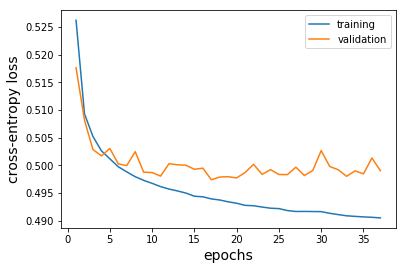

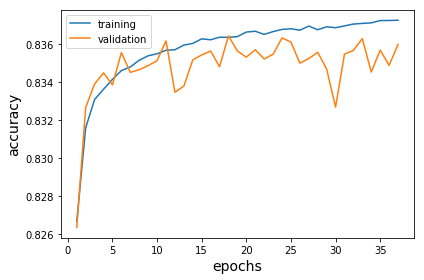

../../models/mc16d_PFlow_ttbar_ip3d/effs_PFN_phi_100_100_128_F_100_100_100_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file


In [3]:
leffs, ceffs, beffs = [],[],[]

modelDir = '../../models/'+subDir
figDir = '../../figures/'
nTest, nTrks, nFeatures = X.shape

# LSTM
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
           dataTag=dataTagTrain+'_sd0_rev', 
           nHidden=100,loadModel=True,nClasses=3)
trainingMetrics(m.modelName, modelDir)
leff, ceff, beff = getEffs(m, X, y, ix,figDir=figDir,subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

# PFN
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

m = myPFN(ppm_sizes, dense_sizes, latent_dropout=0,
          timeSteps=nTrks, nFeatures=nFeatures,
          modelDir=modelDir, dataTag=dataTagTrain, 
          nClasses=3, loadModel=True)
trainingMetrics(m.modelName, modelDir)
leff, ceff, beff = getEffs(m, X, y, ix, figDir=figDir, 
                            subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

**Notes:** Before I was training with an early stopping with a patience of 20, but clearly this was overkill, I should be sufficient using a patience of just 10, and this is also a common value that I've been seeing in papers a lot.

### Step 3: Make the ROC curves

In [16]:
# labels=['LSTM','Deep-Sets']

# l_mod = [x for x in leffs[:1]]
# c_mod = [x for x in ceffs[:1]]
# b_mod = [x for x in beffs[:1]]

# plotROCRatio(b_mod, l_mod, labels, rrange=(0.9,1.1),#text=text,
#              ylabel='l-rej',binomialErrors=False,nTest=nTest,
#              colors=['C2','C4'])#,
#              #figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_cf_lstm')

# plotROCRatio(b_mod, c_mod, labels, rrange=(0.9,1.1),#text=text,
#              ylabel='c-rej',binomialErrors=False,nTest=nTest,
#              colors=['C2','C4'])#,
#              #figDir=figDir,subDir=subDir+'/deep-sets',tag='crej_cf_lstm')


**Lesson:** It seems like my Deep-Sets model is *overfitting* quite a bit more, so I might want to try out some tricks that I have to help suppress overfitting, such as Dropout and BatchNormalization, maybe decreasing the architecture size, or adding in some L2 regularization?

But good news, these follow-up architecture studies will be vastly facilitated by Dan's new architecture studies, and maybe I can check out something else as well?


## Step 3: Rough hyperparameter optimization

Ok, so the first things that I could think of trying right out of the box were doing some experiments with regularization techniques, such as batch norm and dropout.

So, I'm starting out with just trying 3 experiments, but I think in the end, I'll try a random search over the hyperparameters after I better understand the input range that we're interested in.



Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


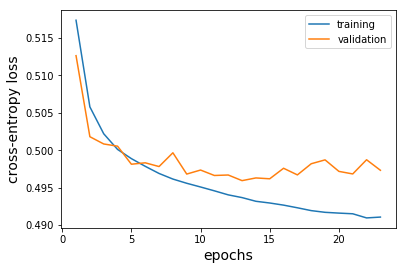

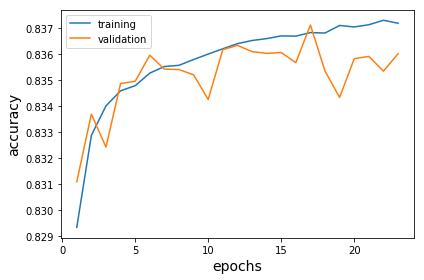

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_dpt_0.2_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


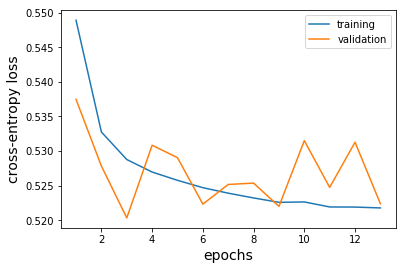

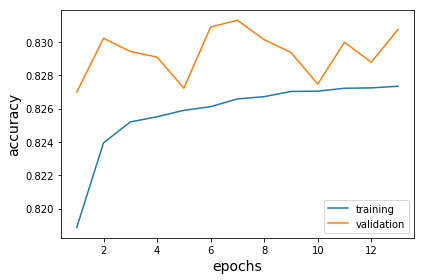

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_dpt_0.2_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


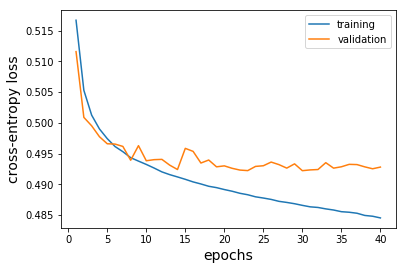

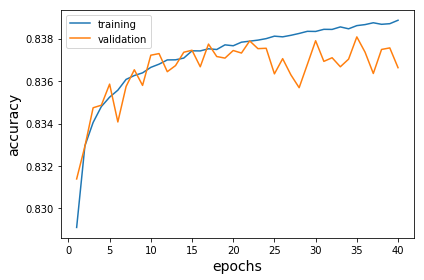

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_dpt_0.2_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


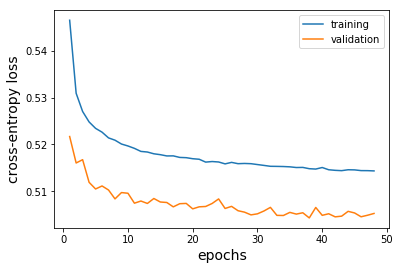

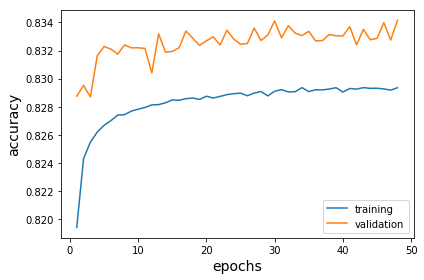

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_dpt_0.2_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file


In [4]:
for batch_norm in [False,True]:
    for dropout in [0,0.2]:
                
        m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                 modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
                 dropout=dropout,batch_norm=batch_norm)
        trainingMetrics(m.modelName, modelDir)
        leff, ceff, beff = getEffs(m, X, y, ix, figDir=figDir, 
                                   subDir=subDir,modelDir=modelDir)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        

In [ ]:
m.modelDir

In [ ]:
m.modelName

**Lesson:**  BatchNorm seems to helping a lot, and some combination of BatchNorm and dropout seems to be doing pretty good.

In [5]:
# labels=['EnergyFlow with default options',
#         'Deep-Sets: Dan\'s net & default options', 
#         'Deep-Sets: dropout rate 0.2',
#         'Deep-Sets: batch norm, no dropout',
#         'Deep-Sets: batch norm, dropout rate 0.2']

# colors= ['C2','C4','C6','C7','C9']

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

# plotROCRatio(beffs[1:6], leffs[1:6], labels, rrange=(0.9,1.1),text=text,
#              ylabel='l-rej',binomialErrors=False,nTest=nTest,
#              colors=colors)#,
#              #figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_cf_lstm')

# plotROCRatio(beffs[1:6], ceffs[1:6], labels, rrange=(0.9,1.1),text=text,
#              ylabel='c-rej',binomialErrors=False,nTest=nTest,
#              colors=colors)#,
#              #figDir=figDir,subDir=subDir+'/deep-sets',tag='crej_cf_lstm')


Ok, let's remake the roc curves with the Deep-Sets from Dan's model with the same default options!

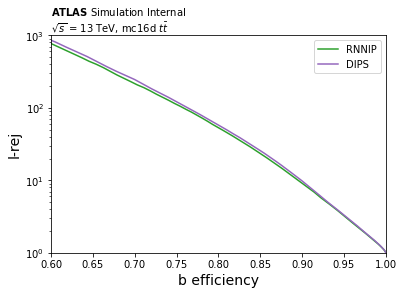

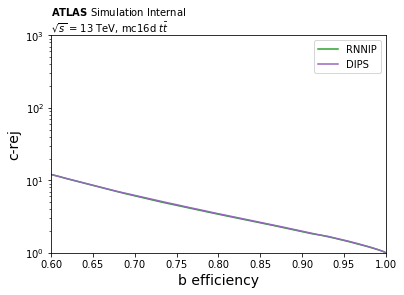

In [12]:
labels=['RNNIP','DIPS']

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d $t\bar{t}$"

# plotROCRatio([beffs[0],beffs[2]], [leffs[0],leffs[2]], labels, rrange=(0.95,1.05),text=text,
#              ylabel='l-rej',binomialErrors=False,nTest=nTest,
#              colors=['C2','C4'])#,
#              #figDir=figDir,subDir=subDir,tag='lrej_cf_lstm')

# plotROCRatio([beffs[0],beffs[2]], [ceffs[0],ceffs[2]], labels, rrange=(0.95,1.05),text=text,
#              ylabel='c-rej',binomialErrors=False,nTest=nTest,
#              colors=['C2','C4'])#,
#              #figDir=figDir,subDir=subDir,tag='crej_cf_lstm')
    
plotROC([beffs[0],beffs[4]], [leffs[0],leffs[4]], labels, text=text,
        ylabel='l-rej', colors=['C2','C4'],
        figDir=figDir,subDir=subDir,tag='lrej_cf_lstm')

plotROC([beffs[0],beffs[4]], [ceffs[0],ceffs[4]], labels, text=text,
        ylabel='c-rej', colors=['C2','C4'],
        figDir=figDir,subDir=subDir,tag='crej_cf_lstm')


## Comparison with and without $\tau$s 

Let's look at if this extra $\tau$ classification node actually helped our performance on $t\bar{t}$.

In [ ]:
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
           dataTag=dataTagTrain+'_sd0_rev', 
           nHidden=100,loadModel=True)
trainingMetrics(m.modelName, modelDir)
leff, ceff, beff = getEffs(m, X, y, ix,figDir=figDir,subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
labels=[r'RNNIP: without $\tau$ output',r'RNNIP: with $\tau$ output']

plotROCRatio([beffs[0],beffs[6]], [leffs[0],leffs[6]], labels, rrange=(0.95,1.05),text=text,
             ylabel='l-rej',binomialErrors=False,nTest=nTest,colors=['C2','C1'],
             figDir=figDir,subDir=subDir,tag='lrej_wo_taus')

plotROCRatio([beffs[0],beffs[6]], [ceffs[0],ceffs[6]], labels, rrange=(0.95,1.05),text=text,
             ylabel='c-rej',binomialErrors=False,nTest=nTest,colors=['C2','C1'],
             figDir=figDir,subDir=subDir,tag='crej_wo_taus')


Lesson: I don't think these 5% discrepancies are important, but I'm not sure if I'm over-interpretting these inputs?

Perhaps I should consider training several versions of the same network to get an idea of the stochasticity of the training?

## Step 3: Performance with flipping

In [ ]:
X_flip = X.copy()
X_flip[:,:,:2] *= -1
X_flip = X_flip[:,::-1]

In [ ]:
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
           dataTag=dataTagTrain+'_sd0_rev', 
           nHidden=100,loadModel=True,nClasses=3)

leff, ceff, beff = getEffs(m, X_flip, y, ix, figDir=figDir, 
                           subDir=subDir,modelDir=modelDir,tag='_flip')

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [ ]:
for batch_norm in [False,True]:
    for dropout in [0,0.2]:
                
        m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                 modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
                 dropout=dropout,batch_norm=batch_norm)
        #trainingMetrics(m.modelName, modelDir)
        leff, ceff, beff = getEffs(m, X_flip, y, ix, figDir=figDir, 
                                   subDir=subDir,modelDir=modelDir,tag='_flip')

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

In [ ]:
# plotROCRatio(beffs, leffs, [str(i) for i,_ in enumerate(beffs)], rrange=(0.9,1.1),#text=text,
#              ylabel='l-rej',binomialErrors=False,nTest=nTest)#,
#              #figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_cf_lstm')

# plotROCRatio(beffs, ceffs, [str(i) for i,_ in enumerate(beffs)], rrange=(0.9,1.1),#text=text,
#              ylabel='c-rej',binomialErrors=False,nTest=nTest)

In [ ]:
labels = ['{}{}'.format(model,config) for config in ['',': flipped'] for model in ['RNN','DIPS','DIPS: dropout','DIPS: batch norm','DIPS: batch norm + dropout']]
labels

In [ ]:
sel_idx = [0,2,3,4,5,-5,-4,-3,-2,-1]

my_beffs = [beffs[i] for i in sel_idx]
my_ceffs = [ceffs[i] for i in sel_idx]
my_leffs = [leffs[i] for i in sel_idx]

colors = ['C2','C4','C6','C7','C9']*2
styles = ['-']*5 + ['--']*5

plotROC(my_beffs, my_leffs, labels,title="Performace from flipping",
        ylabel='l-rej',styles=styles,colors=colors,
        figDir=figDir,subDir=subDir,tag='lrej-scan_bn_dpt')
plotROC(my_beffs, my_ceffs, labels,title="Performace from flipping",
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej-scan_bn_dpt')


In [ ]:
sel_idx = [0,4,-5,-2]

my_beffs = [beffs[i] for i in sel_idx]
my_ceffs = [ceffs[i] for i in sel_idx]
my_leffs = [leffs[i] for i in sel_idx]

colors = ['C2','C4']*2
styles = ['-']*2 + ['--']*2

labels = ['{}{}'.format(model,config) for config in ['',': flipped'] for model in ['RNNIP','DIPS']]
labels

plotROC(my_beffs, my_leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,
        figDir=figDir,subDir=subDir,tag='lrej_dips_bn_flip')
plotROC(my_beffs, my_ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_dips_bn_flip')

**Trying attention**

The permutation invariance of DIPS means that the flipping was not as good as it was for the RNN. Michael suggested trying attention, which is a good idea, so I'll try it out!


In [ ]:
m = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
         modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
         dropout=0,batch_norm=True,attn=True)

trainingMetrics(m.modelName, modelDir)

for Xi,tag in zip([X,X_flip],['','_flip']):
        
    leff, ceff, beff = getEffs(m, Xi, y, ix, figDir=figDir, 
                               subDir=subDir,modelDir=modelDir,tag=tag)

    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)

In [ ]:
sel_idx = [0,2,-2,-7,-6,-1]

my_beffs = [beffs[i] for i in sel_idx]
my_ceffs = [ceffs[i] for i in sel_idx]
my_leffs = [leffs[i] for i in sel_idx]

colors = ['C2','C4','C6']*2
styles = ['-']*3 + ['--']*3

labels = ['{}{}'.format(model,config) for config in ['',': flipped'] for model in ['RNNIP','DIPS','DIPS+attention']]
labels

plotROC(my_beffs, my_leffs, labels,text=text,#title="Performace from flipping",
        ylabel='l-rej',styles=styles,colors=colors)#,
        #figDir=figDir,subDir=subDir,tag='lrej_attn_flip')
plotROC(my_beffs, my_ceffs, labels,text=text,#title="Performace from flipping",
        ylabel='c-rej',styles=styles,colors=colors,ymax=100)#,
        #figDir=figDir,subDir=subDir,tag='crej_attn_flip')